# Tennis Agent Training

## Import libraries

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt

## Create instance of the Tennis environment

In [2]:
env = UnityEnvironment(file_name='Tennis.app') # Update the app name/location if not using macOS

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


# Get brain, number of agents, size of state, and size of action

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Import the Multi Agent Deep Deterministic Policy Gradients (MADDPG) Agent

In [5]:
from ddpg_agent import Agent
from buffer import ReplayBuffer

In [6]:
agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=0)
agent_2 = Agent(state_size=state_size, action_size=action_size, memory=agent_1.memory, random_seed=0)

## Training loop

In [7]:
def ddpg(n_episodes=2000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    add_noise = True
    for i_episode in range(1, n_episodes+1):
        if i_episode > 200:
            add_noise=False
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent_1.reset()
        agent_2.reset()
        scores_ep = np.zeros(num_agents)
        while True:
            action1 = agent_1.act(states[0], add_noise=add_noise).tolist()
            action2 = agent_2.act(states[1], add_noise=add_noise).tolist()
            actions = [action1, action2]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent_1.step(states[0], action1, rewards[0], next_states[0], dones[0])
            agent_2.step(states[1], action2, rewards[1], next_states[1], dones[1])
            scores_ep += rewards
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        scores.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), 
                                                                         max_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, 
                                                                                         np.mean(scores_deque)))
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_1_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_1_critic.pth')
            torch.save(agent_2.actor_local.state_dict(), 'checkpoint_2_actor.pth')
            torch.save(agent_2.critic_local.state_dict(), 'checkpoint_2_critic.pth')
            break
    return scores

In [8]:
scores = ddpg()

Episode 1	Average Score: 0.00	Score: 0.00

/Users/frankhart/anaconda3/envs/tensorflow/lib/python3.5/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.01	Score: 0.10
Episode 300	Average Score: 0.09	Score: 0.20
Episode 400	Average Score: 0.25	Score: 0.10
Episode 429	Average Score: 0.52	Score: 2.60
Environment solved in 429 episodes!	Average Score: 0.52


## Plot the average score during training

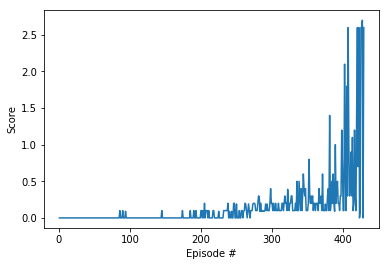

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()